In [1]:
# from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
# import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras.datasets import cifar10

In [2]:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(train_images, y_train), (test_images, y_test) = cifar10.load_data()

input_shape = (img_rows, img_cols, 3)

# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 100

# Convert datasets to floating point types-
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalize the training and testing datasets-
train_images /= 255.0
test_images /= 255.0

print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {train_images.shape} & X_test.shape: {test_images.shape}")



Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 3) & X_test.shape: (10000, 32, 32, 3)


In [3]:
filepath = '/root/.keras/datasets/'
latent_dim = 1024

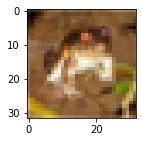

In [4]:
%matplotlib inline
plt.figure(figsize=(2, 2))
plt.imshow(train_images[0,:,:], cmap='gray_r')

In [5]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 3)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

# train_images = preprocess_images(train_images)
# test_images = preprocess_images(test_images)

train_size = train_images.shape[0]
batch_size = 32
test_size = test_images.shape[0]

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [6]:
tr = preprocess_images(train_images)

In [7]:
tr[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [8]:
train_images[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [9]:

class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
              [
                  tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
                  tf.keras.layers.Conv2D(
                      filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                  tf.keras.layers.Conv2D(
                      filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                  tf.keras.layers.Flatten(),
                  # No activation
                  tf.keras.layers.Dense(latent_dim + latent_dim),
              ]
        )
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )
        
    @tf.function
    def sample(self, z=None):
        if z is None:
            z = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(z, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [10]:
latent_dim = 2

epochs = 20

In [11]:
model = CVAE(latent_dim)
model.encoder.summary()
model.decoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 4)                 12548     
                                                                 
Total params: 31,940
Trainable params: 31,940
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (

In [12]:

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

In [13]:
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [14]:

@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [15]:
model = CVAE(latent_dim)

In [19]:
def plot_latent_images(model, n, epoch, im_size=32, save=True, first_epoch=False, f_ep_count=0):
    

    # Create image matrix 
    image_width = im_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    

    # Create list of values which are evenly spaced wrt probability mass

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))


    # For each point on the grid in the latent space, decode and

    # copy the image into the image array
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (im_size, im_size))
            image[i * im_size: (i + 1) * im_size,
                  j * im_size: (j + 1) * im_size] = digit.numpy()
    

    # Plot the image array
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')


    # Potentially save, with different formatting if within first epoch
    if save and first_epoch:
        plt.savefig('tf_grid_at_epoch_{:04d}.{:04d}.png'.format(epoch, f_ep_count))
    elif save:
        plt.savefig('tf_grid_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [20]:
tf.config.run_functions_eagerly(True)
plot_latent_images(model, 20, epoch=0)


optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for idx, train_x in enumerate(train_dataset):
        train_step(model, train_x, optimizer)
        if epoch == 1 and idx % 75 == 0:
            plot_latent_images(model, 20, epoch=epoch, first_epoch=True, f_ep_count=idx)          
    end_time = time.time()
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    if epoch != 1:
        plot_latent_images(model, 10, epoch=epoch)

InvalidArgumentError: Input to reshape is a tensor with 3072 values, but the requested shape has 1024 [Op:Reshape]

In [ ]:
 z = tf.random.normal(shape=(100, 2))

plt.plot(z)

In [ ]:
dec = model.decode(z)

In [ ]:
dec.shape

In [ ]:
plt.imshow(dec[75])